# Correlation Explanation Alternative (CorEx)

**Anchored CorEx: Hierarchical Topic Modeling with Minimal Domain Knowledge**

Topic modeling by way of Correlation Explanation (CorEx) yields rich topics that are maximally informative about a set of data. Unlike LDA, CorEx does not assume a particular data generating model, and instead searches for topics that are “maximally in- formative” about a set of documents. By learning informative topics rather than generated topics, it  avoids specifying the structure and nature of topics ahead of time.

This method  proposes a new way to bypass the limitations of LDA implementation. It introduces a new approach to topic modeling in text classification settings with what the authors call a Correlation Explanation (CorEx). What they claim to achieve is a similar performance and results as LDA, but with a better minimization of human intervention. For that they devised a neat strategy/methodology by an information theoretical framework that uses anchoring of words. These words are introduced as **domain-knowledge anchors** in a way similar to techniques such as the information bottleneck method. In this way the coherence of the overall document classification task is enhanced and  the new topics introduced are better predictors, improving the framework.

**References:**

Discovering Structure in High-Dimensional Data Through Correlation Explanation, Ver Steeg and Galstyan, NIPS 2014.
Maximally Informative Hierarchical Representions of High-Dimensional Data, Ver Steeg and Galstyan, AISTATS 2015.

https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb

In [ ]:
# need this code snippet in each notebook to mount the google drive
from google.colab import drive  
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import nltk
from keras.utils import to_categorical

In [ ]:
!pip install joblib==0.17.0

In [ ]:
os.chdir("/content/gdrive/My Drive/20191101-2020-1031-alerts/python")
!ls

 autoencoder_classifier.h5  'processminer-rare-event-mts - data.csv'
 BerTopic.py		     __pycache__
 embeddings2.joblib	     topic-model-example
 embeddings2.pkl	     training.pdf
 embeddings4.joblib	     weights.best.hdf5
 embeddings.pkl		     y_encoded2.joblib
 frame.csv		     y_encoded4.joblib
 logs			     y_encoded4_multi.joblib
 Netflow_NN.py		     y_encoded.joblib
 process_alerts.py


In [ ]:
df=pd.read_csv("../2019-11-02-alerts.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,14,15,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
list(df.columns)

['tenant',
 'alertDate',
 'uuid',
 'alert_type',
 'severity',
 'creator',
 'message',
 'eventTimestamp',
 'ingestDelay',
 'alertTimestamp',
 'insertDelay',
 'insertTimestamp',
 'labelDelay',
 'labelTimestamp',
 'labelName',
 'labelUser',
 'labelBulk',
 'investigateId']

In [ ]:
# break large file into chunks and process each chunk
fields =['message','labelName']
for df_alerts in pd.read_csv("frame.csv", iterator=True, chunksize=2000000000,usecols=fields,low_memory=False):
    break 
df_alerts.shape

(24141805, 2)

In [ ]:
df_alerts = df_alerts.dropna()

In [ ]:
df_alerts.shape

(7397216, 2)

In [ ]:
df_alerts.columns =['text','labelName']

In [ ]:
df_alerts.sample(5)

,text,labelName
14592173,HTTP: User Authentication Brute Force Attempt,false positive
16233459,WordPress Xmlrpc.php Remote Code Execution Vul...,true positive: benign
1801469,OpenSSL DTLS Buffer Overflow Vulnerability,false positive
22449405,SERVER-OTHER MRLG fastping echo reply memory c...,true positive: benign
12059559,Adobe ColdFusion Local File Include Code Execu...,true positive: benign


In [ ]:
# Python program to Remove all  digits from a list of string 
import re 
docs = df_alerts['text'].tolist()  

def remove(list):
    try: 
       pattern = '[0-9]'
       list = [re.sub(pattern, '', i) for i in list] 
       pattern = 'VID'
       list = [re.sub(pattern, '', i) for i in list]
    except:
       return list 
    return list

# now purge digits from alerts
docs = remove(docs)
df_alerts.text = docs

In [ ]:
df_alerts.sample(5)

,text,labelName
21850473,Cisco Data Center Network Manager Directory Tr...,true positive: benign
7619760,InvalidUninstallGUID,false positive
7660540,InvalidUninstallGUID,false positive
6884851,SERVER-OTHER MRLG fastping echo reply memory c...,true positive: benign
7418448,SuspectActivityInPowerShellHistory,true positive: benign


# **Save dataframe to file for other applications**

In [ ]:
import joblib
joblib.dump(df_alerts,'df_alerts.joblib')

['df_alerts.joblib']

In [ ]:
set(list(df_alerts.labelName))

{'false positive',
 'false-positive',
 'not actionable',
 'not-actionable',
 'true positive',
 'true positive: benign',
 'true positive: malicious',
 'true-positive-benign',
 'true-positive-malicious'}

In [ ]:
# display sample "TRUE POSITIVE MALICIOUS" alerts
df_malicious = df_alerts.loc[(df_alerts['labelName'] == 'true positive: malicious') |(df_alerts['labelName'] == 'true-positive: malicious')]
pd.set_option('display.max_colwidth', 1000)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df_malicious['text'].sample(10).head(10).to_string(index=False)) # sample randomly 10 alerts in this category

                           HTTP Unauthorized Brute Force Attack
 Apache Struts Content-Type Remote Code Execution Vulnerability
          Powershell invoking code from an environment variable
                                   PowerShell Decodes WMI Class
 Apache Struts Content-Type Remote Code Execution Vulnerability
                                    Powershell Encoded Command 
                           HTTP Unauthorized Brute Force Attack
                                      TrickbotConfigsAndModules
                                      TrickbotConfigsAndModules
                                      TrickbotConfigsAndModules


In [ ]:
# display sample "TRUE POSITIVE BENIGN" alerts
df_benign = df_alerts.loc[(df_alerts['labelName'] == 'true positive') |(df_alerts['labelName'] == 'true positive: benign') | (df_alerts['labelName'] == 'true-positive: benign')]
pd.set_option('display.max_colwidth', 1000)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df_benign['text'].sample(10).head(10).to_string(index=False)) # sample randomly 10 alerts in this category

          MALWARE-CNC Win.Dropper.Brusha malicious payload download attempt
            SERVER-OTHER MRLG fastping echo reply memory corruption attempt
   Oracle WebLogic Server Console RCE Attempt GET Request (CVE--) - Inbound
             POLICY-OTHER Microsoft Active Directory DSGetNCChanges attempt
        Cisco Data Center Network Manager Directory Traversal Vulnerability
              Adobe ColdFusion Multiple Directory Traversal Vulnerabilities
                           POLICY-OTHER HTTP request by IPv address attempt
                                                                           
         ... was identified as a malicious IP on the CTU Protection IP List
                                 OpenSSL DTLS Buffer Overflow Vulnerability


In [ ]:
# display sample "FALSE POSITIVE" alerts
df_false_positive = df_alerts.loc[(df_alerts['labelName'] == 'false positive') | (df_alerts['labelName'] == 'false-positive')]
pd.set_option('display.max_colwidth', 1000)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df_false_positive['text'].sample(10).head(10).to_string(index=False)) # sample randomly 10 alerts in this category

 Renamed Windows Scripting Host Running Suspicious JavaScript
                                         InvalidUninstallGUID
                       Emotet Trojan Running Nirsoft Command 
                       Emotet Trojan Running Nirsoft Command 
                                         InvalidUninstallGUID
                                         InvalidUninstallGUID
                                         InvalidUninstallGUID
                                         InvalidUninstallGUID
                                         InvalidUninstallGUID
                                         InvalidUninstallGUID


In [ ]:
# display sample "FALSE POSITIVE" alerts
df_not_actionable = df_alerts.loc[(df_alerts['labelName'] == 'not actionable') | (df_alerts['labelName'] == 'not-actionable')]
pd.set_option('display.max_colwidth', 1000)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df_not_actionable['text'].sample(10).head(10).to_string(index=False)) # sample randomly 10 alerts in this category

              Joomla! .. com_fields SQL Injection Attempt - HTTP GET Inbound
                                     SIP INVITE Method Request Flood Attempt
                            Anonymous Sharing Activity - Used Anonymous Link
                         HTTP Unix Shell IFS Remote Code Execution Detection
                            Anonymous Sharing Activity - Used Anonymous Link
                                        Squid Integer Overflow Vulnerability
 Netis/Netcore Router Default Credential Remote Code Execution Vulnerability
                                        LDAP: User Login Brute Force Attempt
                    Suspicious WebDAV OPTIONS Request to /admin\$ - Outbound
                                      SMB: User Password Brute Force Attempt


In [ ]:
# map targets to numberic
def binary_classes(t):
  if t == 'true positive: malicious' or t == 'true-positive-malicious':
     return 1
  else:  
    return 0

def multi_classes(t):
   if t == 'false positive' or t == 'false-positive':
     return 0
   elif t == 'true positive: benign' or t == 'true-positive-benign':
     return 1
   elif t == 'not actionable' or t == 'not-actionable':
     return 2
   else:  #t == 'true positive: malicious' or t == 'true-positive-malicious':
    return 3

In [ ]:
target = df_alerts['labelName'].tolist()
Class = 2    # flag for choosing between binary =1/multiclass=0 classifier
if Class == 2:
  y = [binary_classes(x) for x in target]
else:
  y = [multi_classes(x) for x in target]

from sklearn.preprocessing import OneHotEncoder
print('Vectorizing Y labels...')
y=np.array(y)
y_encoded = to_categorical(y)

Vectorizing Y labels...


In [ ]:

# Separate majority and minority classes
df = df_alerts
df['balance'] = y

df_majority = df[df.balance==0]
df_minority = df[df.balance==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=73652,     # to match minority class
                                 random_state=123) # reproducible results
 from sklearn.utils import resample
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.balance.value_counts()
# 1    73652
# 0    73652
# Name: balance, dtype: int64

0    73652
1    73014
Name: balance, dtype: int64

In [ ]:
list(y).count(1)

73014

In [ ]:
from sklearn.utils import resample
# Separate majority and minority classes
df = df_alerts
df['balance'] = y
df_majority = df[df.balance==0]
df_minority = df[df.balance==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=7323564,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.balance.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

0    7324202
1    7323564
Name: balance, dtype: int64

**Train/Test Split:**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_alerts['text'], y, test_size=0.1, random_state=np.random.seed(7))
#X_train, X_test, y_train, y_test = train_test_split(df_downsampled['text'], df_downsampled['balance'], test_size=0.1, random_state=np.random.seed(7))
n_classes = len(set(y))

In [ ]:
df_alerts.text

0                                                                                        Suspicious powershell.exe in HTTP URI - Inbound
1                                            SSLv Large Heartbeat Content Detected (from_client) - Possible OpenSSL Exploitation (CVE--)
6           A process using Force Data Execution Prevention (Force DEP) tried to execute non-executable memory. The process was blocked.
10          A process using Force Data Execution Prevention (Force DEP) tried to execute non-executable memory. The process was blocked.
11          A process using Force Data Execution Prevention (Force DEP) tried to execute non-executable memory. The process was blocked.
                                                                        ...                                                             
24141779                                                                                                      Impossible travel activity
24141780                                 

**TFIDF Vectorization of X_train:**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_df=.95,
    min_df=2,
    max_features=None,
    ngram_range=(1,3),
    norm=None,
    binary=True,
    use_idf=True,
    stop_words=['microsoft','securework'],
    sublinear_tf=False
)
vectorizer = vectorizer.fit(X_train)
tfidf = vectorizer.transform(X_train)
vocab = vectorizer.get_feature_names()
print(len(vocab)) # dictionary size

23094


In [ ]:
!pip install corextopic

# Train CorEx Topic Model with alert topic archors

Anchored CorEx allows a user to anchor words to topics in a semi-supervised fashion to uncover otherwise elusive topics.
---



In [ ]:
# Anchors designed to nudge the model towards measuring specific genres
# https://notebook.community/gregversteeg/corex_topic/corextopic/example/corex_topic_example
from corextopic import corextopic as ct
num_of_topics = 4
anchor_words = [
    ["exploit", "blacklist", 'powershell'],
    ["outbound","vulnerability"],
    ["buffer", "overflow"],
    ["flood","attempt"],
]
'''
anchors = [
    [a for a in topic if a in vocab]
    for topic in anchors
]
'''
model = ct.Corex(n_hidden=num_of_topics, seed=42)
model = model.fit(
    tfidf,
    words=vocab,
    anchors=anchor_words, # Pass the anchors in here
    anchor_strength=6 # Tell the model how much it should rely on the anchors
)

In [ ]:
# Now show topic distribution within the each alert
topic_df = pd.DataFrame(
    model.transform(tfidf), 
    columns=["topic_{}".format(i+1) for i in range(num_of_topics)]
).astype(float)
topic_df.index = X_train.index
df = pd.concat([df_alerts, topic_df], axis=1)

In [ ]:
# show topics for trained sample at 1860 index. NEED A WAY TO PREDICT ON NEW DATA
model.transform(tfidf[1260])

array([[ True, False, False, False]])

In [ ]:
d_cloud = pd.DataFrame() 
for i, topic_ngrams in enumerate(model.get_topics(n_words=10)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))
    d_cloud[str(i+1)] = pd.Series(topic_ngrams)

Topic #1: powershell, exploit, wmi, encoded, encoded powershell, wmi launches, powershell command, launches encoded, class, decodes wmi
Topic #2: vulnerability, outbound, remote, execution, code execution, execution vulnerability, remote code, struts, apache struts, apache
Topic #3: overflow, buffer, overflow vulnerability, buffer overflow, openssl dtls, dtls, dtls buffer, openssl, integer overflow, squid integer
Topic #4: attempt, force attempt, user, authentication brute, user authentication, other, authentication, http user, brute


In [ ]:
topic_ngrams
d_cloud

,1,2,3,4
0,powershell,vulnerability,overflow,attempt
1,exploit,outbound,buffer,force attempt
2,wmi,remote,overflow vulnerability,user
3,encoded,execution,buffer overflow,authentication brute
4,encoded powershell,code execution,openssl dtls,user authentication
5,wmi launches,execution vulnerability,dtls,other
6,powershell command,remote code,dtls buffer,authentication
7,launches encoded,struts,openssl,http user
8,class,apache struts,integer overflow,brute
9,decodes wmi,apache,squid integer,NaN


# **Word Cloud:**
Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud. Word clouds are widely used for analyzing data from social network websites such as twitter.

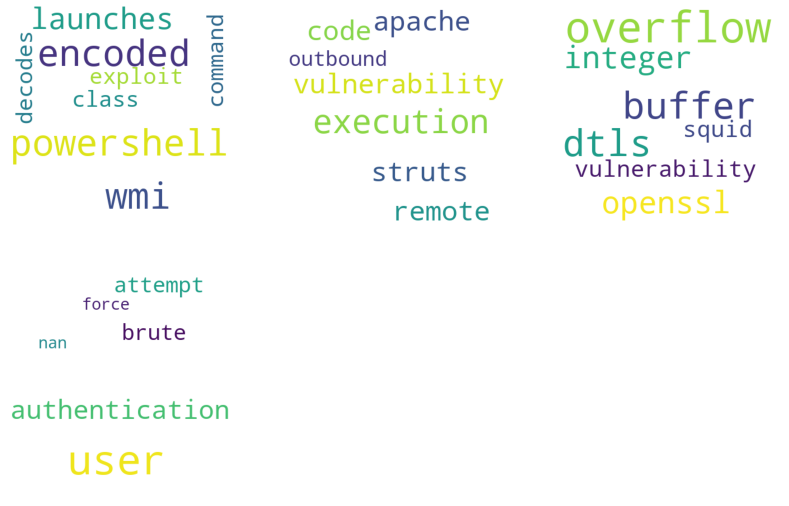

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(14,14))
for i in range(num_of_topics):
    ax = fig.add_subplot(3,3,i+1)
    comment_words = '' 
    stopwords = set(STOPWORDS)
    for val in d_cloud.iloc[:, i]:      
        val = str(val) 
        # split the value 
        tokens = val.split()     
        comment_words += " ".join(tokens)+" " 
    wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
    
    ax.imshow(wordcloud)
    ax.axis('off')


If you have graphviz installed, then you can output visualizations of the hierarchial topic model to your current working directory. One can also create custom visualizations of the hierarchy by properly making use of the labels attribute of each layer.

In [ ]:
#from corextopic import vis_topic as vt
#vt.vis_rep(model, column_label=vocab, prefix='topic-model-example')

#**With Two Topic Archors:**

In [ ]:
# Anchors designed to nudge the model towards measuring specific genres
from corextopic import corextopic as ct
num_of_topics = 2

anchor_words = [["brute force","powershell command","blacklist hit"],["overflow vulnerability"]]

model = ct.Corex(n_hidden=num_of_topics, max_iter=600,seed=42,verbose=False)

model = model.fit(
    tfidf,
    words=vocab,
    anchors=anchor_words, # Pass the anchors in here
    anchor_strength=50 # Tell the model how much it should rely on the anchors
)

In [ ]:
d_cloud = pd.DataFrame() 
for i, topic_ngrams in enumerate(model.get_topics(n_words=10)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))
    d_cloud[str(i+1)] = pd.Series(topic_ngrams)

Topic #1: brute force, brute, force, force attempt, brute force attempt, user, powershell command, authentication brute force, authentication brute, user authentication brute
Topic #2: overflow vulnerability, overflow, buffer overflow vulnerability, buffer overflow, buffer, openssl dtls buffer, dtls buffer, dtls buffer overflow, openssl dtls, dtls


#**Two Topic Word Cloud:**

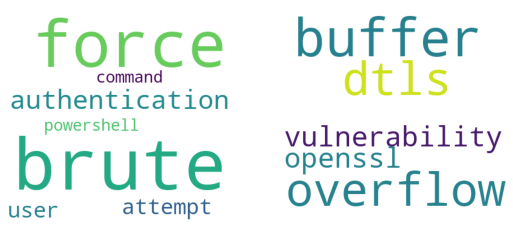

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(14,14))
for i in range(num_of_topics):
    ax = fig.add_subplot(3,3,i+1)
    comment_words = '' 
    stopwords = set(STOPWORDS)
    for val in d_cloud.iloc[:, i]:      
        val = str(val) 
        # split the value 
        tokens = val.split()     
        comment_words += " ".join(tokens)+" " 
    wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
    
    ax.imshow(wordcloud)
    ax.axis('off')

#**Predict Topic on New Data:**

**TFIDF Vectorization of X_test:**

In [ ]:
X_test.head()

3624559                                                                         Email Link
12104485    The application explorer.exe injected code into another process (runonce.exe).
6879318                    SERVER-OTHER MRLG fastping echo reply memory corruption attempt
6748008                    SERVER-OTHER MRLG fastping echo reply memory corruption attempt
1722294                                                 SuspectActivityInPowerShellHistory
Name: text, dtype: object

The topic words are those with the highest mutual information with the topic, rather than 
those with highest probability within the topic as in LDA. The mutual information with the 
topic is the number reported in each tuple. Theoretically, mutual information is always positive. 
If the CorEx output returns a negative mutual information from get_topics(), then the absolute 
value of that quantity is the mutual information between the topic and the absence of that word.

In [ ]:
!pip install fuzzywuzzy

In [ ]:
from fuzzywuzzy import fuzz
def prediction_module(X):
    topics = model.get_topics(n_words=10)
    L = dict()
    scores = dict()
    y_count = dict()
    y_sum = dict()
    y_pred = []
    K  = dict()
    for n, topic in enumerate(topics):
        L[n] = [i[0] for i in topic]
        scores[n] = [i[1] for i in topic]

    for k,item in enumerate(list(X)):  # now score each word in X_test and determine topic for alert
        #s = [x.lower() for x in item.split()]
        #print(k)
        s = item.lower()
        for n,topic in enumerate(topics):
          N = [i for i, j in enumerate(L[n]) if fuzz.ratio(j,s) > 25]
          score = [scores[n][i] for i in N]
          y_count[n] = sum([1 for x in score if x > 0 ])
          y_sum[n] = sum([x for x in score if x > 0 ])
        if y_count[0]  >= 3 and round(y_sum[0],2) > 1.1:  
          #print(y_count[0])
          print(y_sum[0])
          #print(score)
          y_pred.append(1) #topic zero is malicious
        else:
          y_pred.append(0)
    return y_pred   

In [ ]:
# verify ordering with list(y_pred).count(1) with list(y_pred).count(1)
y_pred = prediction_module(X_train[1:10000])
y_pred.count(1)

In [ ]:
fuzz.ratio("large hearbeat",X_train[1].lower())

26

In [ ]:
list(y_train[1:10000]).count(1)

115

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train[1:10000], y_pred,normalize='true')
cm

array([[0.9029745 , 0.0970255 ],
       [0.64347826, 0.35652174]])

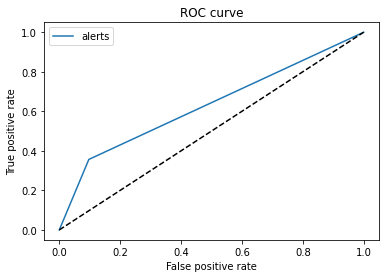

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_train[1:10000], y_pred)
plt.plot(fpr, tpr, label='alerts')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
set(y_pred)

{1}

In [ ]:
!pip install guidedlda

     |████████████████████████████████| 2.1MB 6.1MB/s 
  Created wheel for guidedlda: filename=guidedlda-2.0.0.dev22-cp36-cp36m-linux_x86_64.whl size=2479760 sha256=94fe82bd48e79bb85bb25153a17f9de9c30aed38c1cdd87ab22d3d7245d4d704
  Stored in directory: /root/.cache/pip/wheels/cf/cb/c4/95897cbe4e2e12bd01db3c5cb004c744d2cfd68ecc692ce39e
Successfully built guidedlda
